In [1]:
import pandas as pd
from load_abuse_data import get_abuse_data

In [2]:
df = pd.read_csv("./data/dc_data.csv")


df.head()

,id,title,view_count,recommend_count
0,1,막장드라마 최적화 배우는?,0,0
1,2,"너구리 없고 페이커 1등..LOL 올스타전, 선수 투표 개시",2395,16
2,3,막장드라마 최적화 배우는?,0,0
3,4,리그 오브 레전드 관련 내용이 있어야 합니다.,19916,24
4,5,분석데스크가 왜 좆돌 철밥통인지 이제 알겠네,89,0


In [3]:
df.shape

(1097403, 4)

In [4]:
df.describe()

,id,view_count,recommend_count
count,1.097403e+06,1.097403e+06,1.097403e+06
mean,5.487049e+05,1.352672e+03,3.637459e+00
std,3.167952e+05,9.339565e+03,7.246303e+01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.743515e+05,4.000000e+01,0.000000e+00
50%,5.487070e+05,7.900000e+01,0.000000e+00
75%,8.230575e+05,1.360000e+02,0.000000e+00
max,1.097408e+06,1.059201e+06,1.129600e+04


In [5]:
title_list = list(df.title)


title_list[:10]

['막장드라마 최적화 배우는?',
 '너구리 없고 페이커 1등..LOL 올스타전, 선수 투표 개시',
 '막장드라마 최적화 배우는?',
 '리그 오브 레전드 관련 내용이 있어야 합니다.',
 '분석데스크가 왜 좆돌 철밥통인지 이제 알겠네',
 '에이 싯팔',
 '노브랜드버거 먹어본사람???',
 '막장드라마 최적화 배우는?',
 '지휘관의 깃발, 즈롯차원문도 밸런스 못 잡아 놓고',
 '리신 vs 그브 구도가 어떻게됨?']

In [6]:
abuse_data = get_abuse_data()

In [2]:
from konlpy.tag import Mecab

m = Mecab()

m.nouns(title_list[1])

NameError: name 'title_list' is not defined

In [8]:
dc_nouns_dic = {}


for i, title in enumerate(title_list):
    nouns = m.nouns(title)
    
    for n in nouns:        
        if n not in dc_nouns_dic.keys():
            dc_nouns_dic[n] = 1
            continue

        dc_nouns_dic[n] += 1

In [9]:
dc_nouns_dic = {k: v for k, v in sorted(dc_nouns_dic.items(), key=lambda item: item[1], reverse=True)}

In [10]:
print(f"Nouns Count : {len(dc_nouns_dic)}")
abuse_data = list(set(abuse_data))
print(f"욕설 개수 : {len(abuse_data)}")

Nouns Count : 51855
욕설 개수 : 5073


### 데이터 레이블링
---


- 욕설 사전에 포함된 단어가 존재시 1, 아닐 시 0

In [15]:
title_tag = []


for title in title_list:
    nouns = m.nouns(title)
    title_nouns = " ".join(nouns)
    contain_aubuse_word = False
    for n in nouns:
        if n in abuse_data:
            contain_aubuse_word = True
            break
    
    if contain_aubuse_word:
        title_tag.append([title_nouns, 1])
    else:
        title_tag.append([title_nouns, 0])
    
    
title_tag[:5]

[['막장 드라마 최적화 배우', 0],
 ['너구리 페이커 등 올스타 전 선수 투표 개시', 0],
 ['막장 드라마 최적화 배우', 0],
 ['리그 오브 레전드 관련 내용', 0],
 ['분석 데스크 좆 돌 철 밥통', 1]]

In [16]:
label_df = pd.DataFrame(title_tag, columns=["title_tag", "toxic"])
label_df["id"] = df["id"]


label_df.head()

,title_tag,toxic,id
0,막장 드라마 최적화 배우,0,1
1,너구리 페이커 등 올스타 전 선수 투표 개시,0,2
2,막장 드라마 최적화 배우,0,3
3,리그 오브 레전드 관련 내용,0,4
4,분석 데스크 좆 돌 철 밥통,1,5


In [27]:
label_df["title"] = df["title"]


label_df.head()

,title_tag,toxic,id,title
0,막장 드라마 최적화 배우,0,1,막장드라마 최적화 배우는?
1,너구리 페이커 등 올스타 전 선수 투표 개시,0,2,"너구리 없고 페이커 1등..LOL 올스타전, 선수 투표 개시"
2,막장 드라마 최적화 배우,0,3,막장드라마 최적화 배우는?
3,리그 오브 레전드 관련 내용,0,4,리그 오브 레전드 관련 내용이 있어야 합니다.
4,분석 데스크 좆 돌 철 밥통,1,5,분석데스크가 왜 좆돌 철밥통인지 이제 알겠네


In [34]:
label_df.toxic.value_counts()

0    945484
1    151919
Name: toxic, dtype: int64

In [28]:
total_count = len(label_df.toxic)
toxic_count = label_df.toxic.value_counts()[0]
general_count = label_df.toxic.value_counts()[1]


print(f"일반 문장 : {100 * (general_count / total_count)}, 욕설 문장 {100 * (toxic_count / total_count)}")

일반 문장 : 13.84350143019474, 욕설 문장 86.15649856980527


<AxesSubplot:>

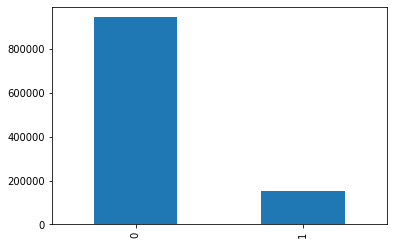

In [18]:
label_df.toxic.value_counts().plot(kind="bar")

### Resampling Data
---


- Random undersampling



In [31]:
count_class_0, count_class_1 = label_df.toxic.value_counts()

# Divide by class
df_class_0 = label_df[label_df['toxic'] == 0]
df_class_1 = label_df[label_df['toxic'] == 1]

Random under-sampling:
1    151919
0    151919
Name: toxic, dtype: int64


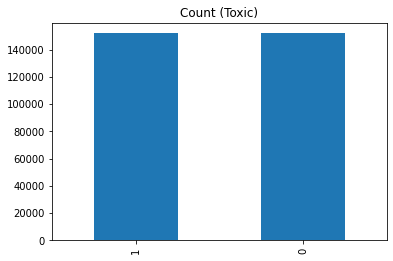

In [37]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.toxic.value_counts())

df_test_under.toxic.value_counts().plot(kind='bar', title='Count (Toxic)');

In [48]:
# save resampling data
# df_test_under.to_csv("./data/resampling_data.csv", index=False)

### Split train, validation, test 
---


- train 60%, valid 20%, test 20%

In [38]:
from sklearn.model_selection import train_test_split

In [44]:
data_x = df_test_under["title"]
data_y = df_test_under["toxic"]


data_x[:3], data_y[:3]

(630317                                      ㅇㅇ
 485785    확팩이 두 개나 나오고 dlc도 존나 많이 나왔는데 볼륨감이 없냐
 173902    페이커와 BTS의 만남, T1 롤 선수단 '달려라 방탄' 출연했다
 Name: title, dtype: object,
 630317    0
 485785    0
 173902    0
 Name: toxic, dtype: int64)

In [45]:
train_x, sub_x, train_y, sub_y = train_test_split(data_x, data_y, test_size=0.4, random_state=42)
valid_x, test_x, test_y, test_y = train_test_split(sub_x, sub_y, test_size=0.5, random_state=42)


print(f"train count : {len(train_x)},  valid count : {len(valid_x)}, test count : {len(test_x)}")

train count : 182302,  valid count : 60768, test count : 60768


### Tokenize
---

- Jamo 단위로 토큰화.

In [19]:
from jamo import h2j, j2hcj

sample_text = "안녕하세요 저는 홍나단입니다."

j2hcj(h2j(sample_text))

'ㅇㅏㄴㄴㅕㅇㅎㅏㅅㅔㅇㅛ ㅈㅓㄴㅡㄴ ㅎㅗㅇㄴㅏㄷㅏㄴㅇㅣㅂㄴㅣㄷㅏ.'

In [20]:
def split_jamo(text):
    return j2hcj(h2j(text))

In [46]:
jamo_train_x = [split_jamo(title) for title in train_x]
jamo_valid_x = [split_jamo(title) for title in valid_x]
jamo_test_x = [split_jamo(title) for title in test_x]

['ㅅㅣㅇㄱㅡㄹㅅㅔ ㅂㅜㄱㅘ, ㅎㅔㅍㅡㄴㅣㅇ… “ㅈㅓㅊㅜㄹㅅㅏㄴ ㅁㅜㄴㅈㅔ ㄴㅗㅇㄷㅏㅁㅇㅣ ㅇㅘㅈㅓㄴ”',
 'ㅂㅔㄹ ㅇㅣㅉㅏㄹ ㅁㅔㅌㅏㄹㅅㅡㄹㄹㅓㄱㅡ ㅇㅚㄱㅖㅇㅣㄴㄱㅏㅌㅇㅣㅅㅐㅇㄱㅕㅆㄴㅡㄴㄷㅔ',
 'ㅇㅣㅈㅔ ㅂㅗㄱㅡㅂㄷㅏㅁㅏ 100ㄱㅐ ㅁㅣㅌㅇㅡㄹㅗ ㄸㅓㄹㅇㅓㅈㅕㅆㄴㅡㄴㄷㅔ',
 'ㄹㅗㄹㄱㅐㄹㄱㅗㄴㅣㄱ ㅌㅏㅂㅋㅐㄹㅣ<<ㅇㅣㅅㅐㄲㅣ ㅌㅏㅂㅋㅐㄹㅣ ㅁㅏㅈㅇㅡㅁ?',
 'ㅈㅗㅁㄲㅗㄹㄹㅣㄴㅡㄴㅂㅔㄹㄹㅏ']